In [83]:
json_prompt = """你精通python代码的静态检查相关的工具和原理，假设我拿到了python工具bandit扫描的结果，结果是json格式的，我需要分析这个结果从而确认是否误报，是否需要高优先级修复。
首先，请根据给出的json数据，帮我找出总共有多少高危（Severity = HIGH）、中危（Severity = MEDIUM）、低危（Severity = LOW）的漏洞。

json数据：
```json
{json_data}
```
"""

## **ssdlc 安全检查结果分析器**

### 步骤一，分析统计结果

In [84]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv("./env/.env"))

import dashscope
from http import HTTPStatus
from pprint import pprint
import json

from langchain.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatTongyi

llm_model = "qwen-max"

llm = ChatTongyi(temperature=1.0, model=llm_model)

json_analysis_prompt = ChatPromptTemplate.from_template(json_prompt)

with open("./data/result.json", "r") as f:
    json_data = json.load(f)

response = llm.invoke(json_analysis_prompt.format_messages(json_data=json_data))

print(response.content)

根据提供的JSON数据，我们可以看到`metrics`字段包含了不同文件的扫描结果摘要信息，而`results`字段则列出了具体的漏洞详情。为了统计高危（Severity = HIGH）、中危（Severity = MEDIUM）和低危（Severity = LOW）漏洞的数量，我们可以直接从`metrics`部分提取这些信息。

从`_totals`字典中可以找到所有文件总的漏洞数量统计，具体如下：

- 高危 (SEVERITY.HIGH): 1
- 中危 (SEVERITY.MEDIUM): 0
- 低危 (SEVERITY.LOW): 3

因此，在整个项目中共发现了1个高危、0个中危以及3个低危级别的安全问题。

如果需要进一步分析每个漏洞的具体情况，包括它们所在的文件位置、相关代码行等细节，可以从`results`数组中获取更详细的信息。例如，第一个高危问题是由于在使用`subprocess.run`时设置了`shell=True`，这可能导致命令注入攻击的风险。这类问题通常建议优先修复以提高应用程序的安全性。对于标记为低危的问题，则可以根据实际情况评估其影响范围后再决定处理优先级。


### 步骤二，提取高危扫描结果


In [85]:
high_risk_prompt = """你精通python代码的静态检查相关的工具和原理，假设我拿到了python工具bandit扫描的结果，结果是json格式的，我需要分析这个结果从而确认是否误报，是否需要高优先级修复。扫描结果格式如下所示：
```json
{{
  "error": [<检查工具报错问题列表>],
  "generated_at": "<生成报告的时间>",
  "metrics": {{
    "<文件名1>": {{
      "CONFIDENCE.HIGH": <当前文件中扫描出的问题信心指数高的个数>,
      "CONFIDENCE.LOW": <当前文件中扫描出的问题信心指数低的个数>,
      "CONFIDENCE.MEDIUM":<当前文件中扫描出的问题信心指数中的个数>,
      "CONFIDENCE.UNDEFINED": <当前文件中扫描出的问题信心指数不确定的个数>,
      "SEVERITY.HIGH": <当前文件中扫描出的问题严重性高的个数>,
      "SEVERITY.LOW": <当前文件中扫描出的问题严重性低的个数>,
      "SEVERITY.MEDIUM": <当前文件中扫描出的问题严重性的中的个数>,
      "SEVERITY.UNDEFINED": <当前文件中扫描出的问题严重性不确定的个数>,
      "loc": <当前文件代码行数>,
      "nosec": <当前文件nosec打标数量>,
      "skipped_tests": <当前文件跳过的测试数量>
    }},
    "<文件名2>": {{...}},
    ...
    "<文件名n>": {{...}},
    "_totals": {{
      "CONFIDENCE.HIGH": <所有文件中扫描出的问题信心指数高的个数>,
      "CONFIDENCE.LOW": <所有文件中扫描出的问题信心指数低的个数>,
      "CONFIDENCE.MEDIUM":<所有文件中扫描出的问题信心指数中的个数>,
      "CONFIDENCE.UNDEFINED": <所有文件中扫描出的问题信心指数不确定的个数>,
      "SEVERITY.HIGH": <所有文件中扫描出的问题严重性高的个数>,
      "SEVERITY.LOW": <所有文件中扫描出的问题严重性低的个数>,
      "SEVERITY.MEDIUM": <所有文件中扫描出的问题严重性的中的个数>,
      "SEVERITY.UNDEFINED": <所有文件中扫描出的问题严重性不确定的个数>,
      "loc": <所有文件代码行数>,
      "nosec": <所有文件nosec打标数量>,
      "skipped_tests": <所有文件跳过的测试数量>
    }},
    "results":[<检查工具扫描出的问题列表>
    <example>
    {{
      "code": "3 import json\n4 import requests\n5 import subprocess\n6 import logging\n7 \n",
      "col_offset": 0,
      "end_col_offset": 17,
      "filename": "./bench/common/system.py",
      "issue_confidence": "HIGH",
      "issue_cwe": {{
        "id": 78,
        "link": "https://cwe.mitre.org/data/definitions/78.html"
      }},
      "issue_severity": "LOW",
      "issue_text": "Consider possible security implications associated with the subprocess module.",
      "line_number": 5,
      "line_range": [
        5
      ],
      "more_info": "https://bandit.readthedocs.io/en/1.8.0/blacklists/blacklist_imports.html#b404-import-subprocess",
      "test_id": "B404",
      "test_name": "blacklist"
    }}
    </example>
    ]
  }}
}}
```

你需要做的事情是：
1.请根据给出的json数据，帮我找出总共有多少高危（Severity = HIGH）、中危（Severity = MEDIUM）、低危（Severity = LOW）的漏洞。
2.输出扫描结果中高危的问题列表。
3.根据扫描结果中metrics记录，帮我找出扫描结果中，存在高危漏洞的文件列表。

要求：
1.根据我的要求帮我完成上述任务，不要做其他事情。
2.不需要输出任何解释，只需要按照我的要求做完事就好。
3.输出必须是json格式，包括扫描结果的总数量和问题列表。
4.输出结果不需要包括```json, ```这样符号。
5.输出格式如下：
```json
{{
  "total_vulnerabilities":{{
    "high_severity": <高危问题数量>,
    "medium_severity": <中危问题数量>,
    "low_severity": <低危问题数量>,
  }},
  "high_severity_issues": [
    {{
      "code": <问题代码>,
      "col_offset": <问题的描述>,
      "end_col_offset": <问题的严重程度>,
      "filename": <问题的修复建议>,
      "issue_confidence": <参考资料链接>,
      "issue_cwe": {{
        "id": <CWE编号>,
        "name": <CWE名称>
      }},
      "issue_severity": <问题严重等级>,
      "issue_text": <问题描述>,
      "line_range": <问题所在行>,
      "more_info": <问题修复建议>,
      "test_id": <问题类型>,
      "test_name": <问题类型名称>
    }},
    ...
  ],
  "files_with_high_severity_issues": [
    <文件路径>,
    ...
  ],
}}
```

json数据：
```json
{json_data}
```
"""

high_risk_analysis_prompt = ChatPromptTemplate.from_template(high_risk_prompt)

response = llm.invoke(high_risk_analysis_prompt.format_messages(json_data=json_data))

high_risk = response.content
pprint("".join(high_risk))

('{\n'
 '  "total_vulnerabilities": {\n'
 '    "high_severity": 1,\n'
 '    "medium_severity": 0,\n'
 '    "low_severity": 3\n'
 '  },\n'
 '  "high_severity_issues": [\n'
 '    {\n'
 '      "code": "37     result = subprocess.run(\\n38         '
 'command,\\n39         shell=True,\\n40         close_fds=True,\\n41         '
 'cwd=cwd,\\n42         stderr=subprocess.PIPE,\\n43         '
 'stdout=subprocess.PIPE\\n44     )\\n45 \\n46     suc = (result.returncode == '
 "0)\\n47     out = result.stdout.decode('UTF-8', 'strict').strip()\\n48     "
 'error = result.stderr.decode(\'UTF-8\', \'strict\').strip()\\n",\n'
 '      "col_offset": 13,\n'
 '      "end_col_offset": 5,\n'
 '      "filename": "./bench/common/system.py",\n'
 '      "issue_confidence": "HIGH",\n'
 '      "issue_cwe": {\n'
 '        "id": 78,\n'
 '        "name": "Improper Neutralization of Special Elements used in an OS '
 'Command (\'OS Command Injection\')"\n'
 '      },\n'
 '      "issue_severity": "HIGH",\n'
 '      "i

### 步骤三，提取高危问题源码和CWE信息

In [86]:
risk_data = json.loads(high_risk)
risk_code = risk_data["high_severity_issues"][0]["code"]

import os
source_code_path = os.path.join(
    "./data", "keentune-bench-3.0.0", risk_data["files_with_high_severity_issues"][0]
)
cwd_78_path = os.path.join("./data", "cwe-78.md")

source_code = open(source_code_path, "r").read()
cwe_78 = open(cwd_78_path, "r").read()
from IPython.display import display,Markdown
display(Markdown(
f"""```python
{risk_code}
```
---
```python
{source_code}
```
---
{cwe_78[:2000]}

...
"""))

```python
37     result = subprocess.run(
38         command,
39         shell=True,
40         close_fds=True,
41         cwd=cwd,
42         stderr=subprocess.PIPE,
43         stdout=subprocess.PIPE
44     )
45 
46     suc = (result.returncode == 0)
47     out = result.stdout.decode('UTF-8', 'strict').strip()
48     error = result.stderr.decode('UTF-8', 'strict').strip()

```
---
```python
# Copyright (c) 2021-2023 Alibaba Cloud Computing Ltd.
# SPDX-License-Identifier: MulanPSL-2.0
import json
import requests
import subprocess
import logging

logger = logging.getLogger('common')


def proc_alive(pid):
    try:
        os.kill(pid, 0)
        return True
    except:
        return False


def httpResponse(response_data, response_ip, response_port):
    logger.info("send response to {ip}:{port}:{data}".format(
        ip = response_ip,
        port = response_port,
        data = response_data
    ))
    try:
        requests.post(
            url = "http://{ip}:{port}/benchmark_result".format(ip = response_ip, port = response_port),
            data = json.dumps(response_data),
            timeout = 3)
    except requests.exceptions.ConnectTimeout:
        logger.warning("send response timeout: ip = {}, port = {}".format(response_ip, response_port))
        
        
def sysCommand(command: str, cwd: str = "./"):
    '''Run system command with subprocess.run and return result
    '''
    result = subprocess.run(
        command,
        shell=True,
        close_fds=True,
        cwd=cwd,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE
    )

    suc = (result.returncode == 0)
    out = result.stdout.decode('UTF-8', 'strict').strip()
    error = result.stderr.decode('UTF-8', 'strict').strip()

    if not suc:
        return suc, error
    else:
        return suc, out


def checkAddressAvaliable(address_list: list):
    result = {}
    for ip in address_list:
        logger.debug("ping -W 1 -c 1 {}".format(ip))
        try:
            suc, _ = sysCommand("ping -W 1 -c 1 {ip}".format(ip = ip))
            if not suc:
                logger.warning("Failed to ping {}".format(ip))
            else:
                logger.debug("Success to ping {}".format(ip))
            result[ip] = suc
        
        except Exception as e:
            logger.error("fail to ping {}: {}".format(ip, e))
            result[ip] = False

    return result

```
---
## CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
--------------------------------------------------------------------------------------------------

Weakness ID: 78

------------------

### Description

The product constructs all or part of an OS command using externally-influenced input from an upstream component, but it does not neutralize or incorrectly neutralizes special elements that could modify the intended OS command when it is sent to a downstream component.


### Extended Description

This weakness can lead to a vulnerability in environments in which the attacker does not have direct access to the operating system, such as in web applications. Alternately, if the weakness occurs in a privileged program, it could allow the attacker to specify commands that normally would not be accessible, or to call alternate commands with privileges that the attacker does not have. The problem is exacerbated if the compromised process does not follow the principle of least privilege, because the attacker-controlled commands may run with special system privileges that increases the amount of damage.

There are at least two subtypes of OS command injection:

*   The application intends to execute a single, fixed program that is under its own control. It intends to use externally-supplied inputs as arguments to that program. For example, the program might use system("nslookup \[HOSTNAME\]") to run nslookup and allow the user to supply a HOSTNAME, which is used as an argument. Attackers cannot prevent nslookup from executing. However, if the program does not remove command separators from the HOSTNAME argument, attackers could place the separators into the arguments, which allows them to execute their own program after nslookup has finished executing.
*   The application accepts an input that it uses to fully select which program to run, as well as which commands to use. The application simply redirects this entire command

...


### 步骤四，提取高危源码的调用关系

根据你提供的JSON数据和源代码，我们可以分析出高危问题代码段属于哪个函数，并找出该函数的调用链。

### 1. 找出问题代码段在源码文件中属于哪个函数

从JSON数据中的`"code"`字段可以看到问题代码段如下：

```python
37     result = subprocess.run(
38         command,
39         shell=True,
40         close_fds=True,
41         cwd=cwd,
42         stderr=subprocess.PIPE,
43         stdout=subprocess.PIPE
44     )
45 
46     suc = (result.returncode == 0)
47     out = result.stdout.decode('UTF-8', 'strict').strip()
48     error = result.stderr.decode('UTF-8', 'strict').strip()
```

通过比对源代码，可以发现这段代码位于`sysCommand`函数中。具体来说，`sysCommand`函数的定义如下：

```python
def sysCommand(command: str, cwd: str = "./"):
    '''Run system command with subprocess.run and return result
    '''
    result = subprocess.run(
        command,
        shell=True,
        close_fds=True,
        cwd=cwd,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE
    )

    suc = (result.returncode == 0)
    out = result.stdout.decode('UTF-8', 'strict').strip()
    error = result.stderr.decode('UTF-8', 'stri

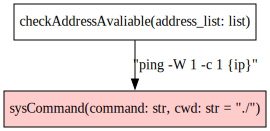

In [94]:
parse_high_risk_call_graph_template = """你是一个精通python语言分析的专家，我会给你一段含有python代码高危问题的json数据，数据格式为：
```json
{{
  "total_vulnerabilities":{{
    "high_severity": <高危问题数量>,
    "medium_severity": <中危问题数量>,
    "low_severity": <低危问题数量>,
  }},
  "high_severity_issues": [
    {{
      "code": <问题代码>,
      "col_offset": <问题的描述>,
      "end_col_offset": <问题的严重程度>,
      "filename": <问题的修复建议>,
      "issue_confidence": <参考资料链接>,
      "issue_cwe": {{
        "id": <CWE编号>,
        "name": <CWE名称>
      }},
      "issue_severity": <问题严重等级>,
      "issue_text": <问题描述>,
      "line_range": <问题所在行>,
      "more_info": <问题修复建议>,
      "test_id": <问题类型>,
      "test_name": <问题类型名称>
    }},
    ...
  ],
  "files_with_high_severity_issues": [
    <文件路径>,
    ...
  ],
}}
```

python代码高危问题json数据为：
{high_risk}

同时我还会提供源码内容{source_code}以供你进行python的分析。

你需要做的事情是：
1.找出问题代码段在源码文件中属于哪个函数
2.找出第1步中函数调用链
"""

parse_high_risk_call_graph_prompt = ChatPromptTemplate.from_template(
    parse_high_risk_call_graph_template
)

response = llm.invoke(
    parse_high_risk_call_graph_prompt.format_messages(high_risk=high_risk, source_code=source_code)
)

high_risk_call_graph = response.content

print(high_risk_call_graph)


dot_graph_description = """你是一个精通DOT语言描述代码调用关系图（call graph）的专家，请根据我给出的python代码高危问题json数据和高危问题所在函数及其调用点数据，用dot语言描述该代码调用关系图。

**要求：**
1.你不需要做其他任何事情，只需要用dot语言把代码调用关系图出来就可以；
2.你可以根据自己对dot语言的理解进行编写生成dot语言描述，但请确保你的描述符合dot语言语法，并且能正确描述出代码调用关系图；
3.你的描述需要包含函数名、函数参数、函数返回值、函数调用链、参数样例等必要信息，但不要包含函数体；
4.如果dot语言描述过程中遇到存在高危问题的函数时，通过设置节点颜色为淡红色的方式来突出该节点，其他节点保持黑底白字即可；
5.生成的内容除了dot语言之外不要包括其他任何内容，也不要包含```dot和```这类非dot语言语法的内容；


python代码高危问题json数据为：
{high_risk}

高危问题所在函数及其调用点数据为：
{high_risk_call_graph}
"""
dot_graph_prompt = ChatPromptTemplate.from_template(dot_graph_description)

response = llm.invoke(
    dot_graph_prompt.format_messages(high_risk=high_risk, high_risk_call_graph=high_risk_call_graph)
)

dot_graph = response.content

print(dot_graph)

from graphviz import Source
from IPython.display import SVG, display

dot_call_graph = Source(dot_graph, filename="output-graph.gv", format="svg")
display(SVG(dot_call_graph.pipe().decode("utf-8")))

### 步骤五，CWE危险等级分析

In [95]:
cwe_severity_analysis_template = """你是一个精通python语言的安全工程师，你精通CWE漏洞的利用。我会给出一段有高危问题的源码和高危问题所在函数的调用链，同时我还会给出高危问题的CWE信息，
CWE信息包括：
- CWE名称
- CWE编号（Weakness ID）
- CWE描述（Description， Extended Description）
- CWE常见的后果（Common Consequence）
- CWE修复建议（Potential Mitigations），修复建议会根据不同阶段Phase给出办法，例如：架构设计阶段Phase: Architecture and Design

你的任务是根据CWE信息对高危问题进行分析：
1.根据高危问题以及其函数调用链的信息，结合CWE信息，给出该问题的影响和后果；
2.根据函数调用链信息以及源码，结合CWE描述和修复建议等信息，给出该高危问题被外部调用者利用的可能性和难易程度；
3.根据CWE的修复建议、函数调用链、该高危问题被利用的可能性和难易程度，给出该高危问题的修复建议；
4.根据上面步骤1，2，3的分析结果，给出该高危问题的分析总结；

要求：
- 输出结果的标题为"SSDLC高危问题分析报告"；
- 需要按照分析过程进行内容输出，包括：1.问题的影响和后果；2.利用的可能性和难易程度；3.修复建议；4.分析总结；
- 输出结果时需要按照分析过程包括你使用的数据来源，分析方法，以及你如何结合CWE信息对问题的影响和后果进行评估；
- 给出的修复建议中要考虑函数调用链上每个函数的参数和返回值；
- 为了方便快速识别和理解该高危问题，高危问题分析总结中，根据该高危问题被外部调用者利用的可能性是由高到低、难易程度由容易到困难以及修复问题的难度由简单到困难，给出总结评估打分；

高危问题所在源码：
```python
{source_code}
```

高危问题所在函数调用链情况：
```python
{high_risk_call_graph}
```

CWE信息如下：
```markdown
{cwe_info}
```
"""

cwe_severity_analysis_prompt = ChatPromptTemplate.from_template(
    cwe_severity_analysis_template
)

response = llm.invoke(
    cwe_severity_analysis_prompt.format_messages(
        source_code=source_code,
        high_risk_call_graph=high_risk_call_graph,
        cwe_info=cwe_78,
    )
)

cwe_severity_analysis = response.content

### 步骤六，生成ssdlc扫描分析报告

In [96]:
display(Markdown(cwe_severity_analysis))

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### CWE-78: 不当的OS命令中特殊元素的中和（'OS命令注入'）

**CWE编号**: 78

**描述**:
该弱点涉及使用外部影响的输入来构建全部或部分OS命令，但没有正确中和或错误地中和可能修改预期OS命令的特殊元素。这可能导致在攻击者无法直接访问操作系统的环境中（如Web应用程序）发生漏洞。如果该弱点出现在特权程序中，它可能会允许攻击者指定通常无法访问的命令，或者以攻击者不具备的权限调用其他命令。

**常见后果**:
- **机密性**: 攻击者可以执行未经授权的操作系统命令，从而读取敏感文件或数据。
- **完整性**: 攻击者可以修改文件或目录，篡改应用程序数据。
- **可用性**: 攻击者可以通过执行恶意命令导致系统崩溃、重启或服务不可用。
- **不可否认性**: 由于命令是由目标应用程序直接执行的，任何恶意活动可能看起来像是来自应用程序或其所有者。

### 影响评估
根据提供的代码和调用链，`sysCommand`函数中的`subprocess.run`调用存在潜在的OS命令注入风险。攻击者可以通过控制传递给`checkAddressAvaliable`函数的IP地址列表来注入恶意命令。例如，攻击者可以提供一个包含特殊字符的IP地址，从而在`ping`命令中注入额外的命令。

## 2. 利用的可能性和难易程度

### 调用链分析
- `checkAddressAvaliable` -> `sysCommand`

`checkAddressAvaliable`函数接受一个IP地址列表，并对每个IP地址调用`sysCommand`函数。`sysCommand`函数使用`subprocess.run`执行命令，并且`command`参数是直接从`checkAddressAvaliable`传递过来的。

### 利用可能性
- **可能性**: 高
  - 攻击者可以通过控制IP地址列表中的值来注入恶意命令。
  - 由于`subprocess.run`使用`shell=True`，攻击者可以利用Shell元字符来注入额外的命令。

### 利用难易程度
- **难易程度**: 容易
  - 攻击者只需要提供一个包含特殊字符的IP地址即可触发命令注入。
  - 例如，攻击者可以提供一个类似`192.168.1.1; rm -rf /`的IP地址，从而删除系统中的文件。

## 3. 修复建议

### 修复策略
- **架构设计阶段**
  - 尽可能使用库调用来替代外部进程调用，以实现所需的功能。
  - 使用沙箱或Jail环境来限制进程与操作系统的交互。
  - 减少攻击面，尽量减少外部控制的数据量。
  - 确保客户端的安全检查也在服务器端进行，以防止绕过客户端检查。

- **实现阶段**
  - 对输出进行编码和转义，确保特殊字符被正确处理。
  - 使用参数化的方法来调用命令，而不是使用单个字符串。
  - 进行严格的输入验证，只接受已知的有效输入。
  - 使用编译或构建时的强化措施，自动传播污点并防止使用污点变量执行命令。
  - 在运行时使用应用防火墙来检测和阻止针对此弱点的攻击。

### 具体修复建议
1. **使用参数化方法调用命令**:
   修改`sysCommand`函数，使用`subprocess.run`的参数列表形式来避免Shell元字符的注入。

   ```python
   def sysCommand(command: str, cwd: str = "./"):
       '''Run system command with subprocess.run and return result
       '''
       try:
           result = subprocess.run(
               command.split(),
               close_fds=True,
               cwd=cwd,
               stderr=subprocess.PIPE,
               stdout=subprocess.PIPE
           )
       except Exception as e:
           logger.error(f"Failed to run command {command}: {e}")
           return False, str(e)

       suc = (result.returncode == 0)
       out = result.stdout.decode('UTF-8', 'strict').strip()
       error = result.stderr.decode('UTF-8', 'strict').strip()

       if not suc:
           return suc, error
       else:
           return suc, out
   ```

2. **输入验证**:
   在`checkAddressAvaliable`函数中添加IP地址验证，确保IP地址格式正确且不包含特殊字符。

   ```python
   import re

   def is_valid_ip(ip: str) -> bool:
       pattern = re.compile(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$')
       if not pattern.match(ip):
           return False
       parts = ip.split('.')
       for part in parts:
           if int(part) > 255:
               return False
       return True

   def checkAddressAvaliable(address_list: list):
       result = {}
       for ip in address_list:
           if not is_valid_ip(ip):
               logger.warning(f"Invalid IP address: {ip}")
               result[ip] = False
               continue
           logger.debug(f"ping -W 1 -c 1 {ip}")
           try:
               suc, _ = sysCommand(f"ping -W 1 -c 1 {ip}")
               if not suc:
                   logger.warning(f"Failed to ping {ip}")
               else:
                   logger.debug(f"Success to ping {ip}")
               result[ip] = suc
           except Exception as e:
               logger.error(f"Fail to ping {ip}: {e}")
               result[ip] = False
       return result
   ```

3. **最小权限原则**:
   确保运行该代码的用户具有最低限度的权限，以减少潜在的损害。

4. **日志记录**:
   详细记录错误信息，但不要泄露敏感信息。确保错误信息不会暴露内部状态。

## 4. 分析总结

### 综合评估
- **利用可能性**: 高
- **利用难易程度**: 容易
- **修复难度**: 中等

### 总结
- **高危问题**: `sysCommand`函数中的`subprocess.run`调用存在OS命令注入风险。
- **影响和后果**: 攻击者可以执行未经授权的命令，导致系统崩溃、数据泄露或篡改。
- **利用可能性和难易程度**: 攻击者通过控制IP地址列表中的值可以轻松注入恶意命令。
- **修复建议**: 使用参数化方法调用命令，进行严格的输入验证，确保运行在最小权限环境下，并记录详细的日志信息。

通过上述分析和修复建议，可以有效降低该高危问题的风险。